In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap

In [2]:
model_ids = ["ACH-000323", "ACH-002083", "ACH-002228"]
files = {
    "Reactome Pathways": "./results/all_reactome_results.parquet",
    "CORUM Complexes": "./results/all_corum_results.parquet",
    "Drug Responses": "./results/all_drug_results.parquet"
}
# Adjust these if your column names differ
feature_colnames = {
    "Reactome Pathways": "reactome_pathway",
    "CORUM Complexes": "reactome_pathway",
    "Drug Responses": "name"
}
score_col = "pathway_score"

model_colors = {
    "ACH-000323": "#00FFFF",  # cyan
    "ACH-002083": "#FF69B4",  # pink
    "ACH-002228": "#800080",  # purple
}

In [ ]:
def clean_label(x: str) -> str:
    """
    Clean or override specific long labels before truncation.
    """
    # Polymerase switching
    if "Polymerase Switching" in x:
        return "Polymerase Switching"

    # Negative MET regulation
    if "Negative Regulation Of MET" in x or "Negative Regulation of MET" in x:
        return "Negative MET Regulation"

    return truncate_label(x)


def truncate_label(
    label: str,
    max_chars_per_line: int = 22,
    max_total_words: int = 4,
    max_lines: int = 2
) -> str:
    """
    Truncate a label according to character and line limits.
    """
    words = label.split()
    short = " ".join(words[:max_total_words])
    
    # Wrap
    lines = textwrap.wrap(short, width=max_chars_per_line)
    
    # clamp to max lines
    if len(lines) > max_lines:
        lines = lines[:max_lines]

    wrapped = "\n".join(lines)

    # Determine if truncated
    if (
        len(words) > max_total_words or 
        (len(lines) >= max_lines and len(lines) < len(textwrap.wrap(short, width=max_chars_per_line)))
    ):
        wrapped += "..."
        
    return wrapped


def place_labels_polar(
    ax,
    angles,
    labels,
    radius: float
) -> None:
    """
    Place labels around a polar plot at a given radius.
    """
    for angle, label in zip(angles[:-1], labels):
        r = radius

        # left / right alignment
        if 0 <= angle <= np.pi/2 or 3*np.pi/2 <= angle <= 2*np.pi:
            ha = 'left'
        else:
            ha = 'right'

        ax.text(
            angle, r, label,
            fontsize=9,
            color='black',
            ha=ha,
            va='center',
            wrap=True
        )

    return None


def make_radar(
    ax,
    df: pd.DataFrame,
    feature_col: str,
    title: str,
    global_max: float,
    num_circles: int = 5
) -> None:
    """
    Draw a radar plot on an existing polar matplotlib axis.
    """
    df = df[df["ModelID"].isin(model_ids)].copy()

    # Top 5 per model, union of all
    top_by_model = (
        df.groupby("ModelID", group_keys=False)
        .apply(lambda x: x.nlargest(5, score_col))
        .reset_index(drop=True)
    )
    top_features = top_by_model[feature_col].drop_duplicates().tolist()
    n_vars = len(top_features)
    labels = [clean_label(x) for x in top_features]

    # Angles
    angles = np.linspace(0, 2 * np.pi, n_vars, endpoint=False).tolist()
    angles += [angles[0]]

    # Reference circles
    circle_levels = np.linspace(0, global_max, num_circles + 1)[1:]
    for r in circle_levels:
        circle_vals = [r] * (n_vars + 1)
        ax.plot(
            angles, circle_vals,
            color="grey", linestyle="--",
            linewidth=1, zorder=0
        )

    # Plot each model
    for mid in model_ids:
        subset = df[df["ModelID"] == mid]

        merged = pd.DataFrame({feature_col: top_features}).merge(
            subset[[feature_col, score_col]],
            on=feature_col,
            how="left"
        )

        values = merged[score_col].fillna(0).tolist()
        values += [values[0]]

        ax.plot(angles, values, color=model_colors[mid],
                linewidth=3, label=mid)
        ax.scatter(angles, values, color=model_colors[mid],
                   s=30, edgecolor="black", zorder=5)

    # Axis styling
    ax.set_ylim(0, global_max * 1.25)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")

    # Labels
    label_radius = global_max * 1.4
    place_labels_polar(ax, angles, labels, label_radius)

    # Title
    ax.set_title(title, fontsize=18, pad=30, fontweight="bold", y=1)

    return None

NameError: name 'matplotlib' is not defined

/tmp/ipykernel_7768/2972962854.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(5, score_col))
/tmp/ipykernel_7768/2972962854.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(5, score_col))
/tmp/ipykernel_7768/2972962854.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a fut

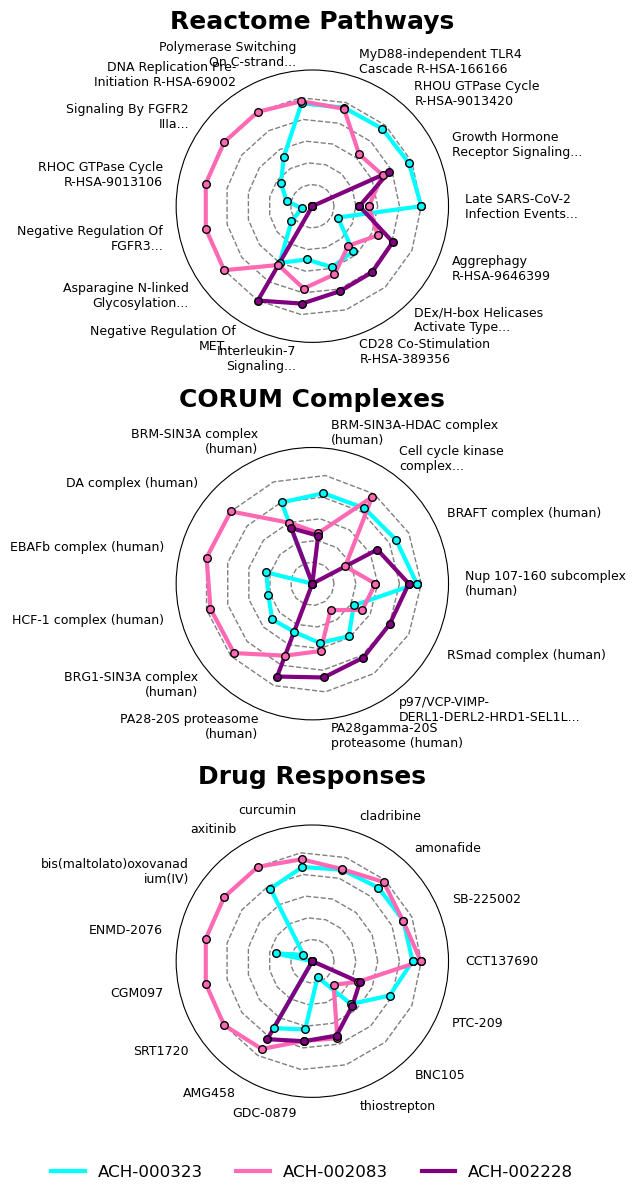

In [ ]:
global_max = 0
dfs = {}
for name, file in files.items():
    df = pd.read_parquet(file)
    dfs[name] = df
    if df[score_col].max() > global_max:
        global_max = df[score_col].max()

# --- Create one combined figure ---
fig, axes = plt.subplots(3, 1, figsize=(18, 12),
                         subplot_kw=dict(polar=True))

for ax, (title, df) in zip(axes, dfs.items()):
    make_radar(ax, df, feature_colnames[title], title, global_max)

# Shared legend (one for all)
handles, labels = axes[0].get_legend_handles_labels()

fig.legend(handles, labels, loc='lower center', ncol=3,
           fontsize=12, frameon=False, bbox_to_anchor=(0.5, -.05))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("visualize/combined_radar_plots.png", dpi=600,
            bbox_inches="tight", transparent=True)
plt.show()